In [1]:
import os, glob
from tqdm import tqdm  # Make sure you're using this one for terminal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from datetime import datetime

from scipy import stats
from scipy.stats import norm

from statsmodels.formula.api import ols
import statsmodels.api as sm

In [2]:
from utils import (calc_performance, calc_paired_performance, calc_performance_target_group_noprobe, calc_performance_target_group_yesprobe, calc_performance_target, calc_performance_group, calc_performance_target_group, 
                   fit_ols_get_beta, run_bootstrapping, grouper, summarize_img_hit_by_duration, stack_data_for_bootstrapping)

In [3]:
paper_data_dir = '../data/'

# 0. Data cleaning

The main data file for Study 2 is RecMem_RSVP_data.csv. Below is an explanation for each of the column:

ID_REDACT:	Participant's Prolific ID (Partially redacted for privacy)

Condition:	Condition of the curren trial (Distintiveness level, Reconstruction error [RE] level and Duration [2: 34 ms, 5: 85 ms, 10: 167 ms])

target_img_1:	The first image shown in the RSVP sequence ('_F': denotes that this is a filler image; '_T' denotes that this is a target image)

target_img_2:	The second image shown in the RSVP sequence('_F': denotes that this is a filler image; '_T' denotes that this is a target image)

target_img_3:	The third image shown in the RSVP sequence ('_F': denotes that this is a filler image; '_T' denotes that this is a target image)

target_img_4:	The fourth image shown in the RSVP sequence ('_F': denotes that this is a filler image; '_T' denotes that this is a target image)

target_img_5:	The fifth image shown in the RSVP sequence ('_F': denotes that this is a filler image; '_T' denotes that this is a target image)

target_img_6:	The sixth image shown in the RSVP sequence ('_F': denotes that this is a filler image; '_T' denotes that this is a target image)

test_img:	The test image shown ('_F': denotes that this is a filler image; '_T' denotes that this is a target image)

response:	Participant's reponse (YES: participant thinks the target was present; NO: participant thinks the target was not present)

TrialType:	Trial type (correct response, YES: the target was present; NO: the target was not present)

timestamp: the time when the participant's response was recorded

In [23]:
subs_responses = pd.read_csv(os.path.join(paper_data_dir, 'output_5_4_824.csv'))

# filter out columns
# covert respose NA to No

target_table = pd.read_csv(os.path.join(paper_data_dir, 'output_5_4_824.csv'))
memorability_table = pd.read_csv(os.path.join(paper_data_dir, 'target_info.csv'))
memorability_table['Memorability'] = memorability_table['hit'] - memorability_table['fa']


# Initialize the 'Memorability' column in the target table
target_table['Memorability'] = None

# Loop through rows of the target table
for index, row in target_table.iterrows():
    mem_scores = []
    
    # Loop through each target image column
    for col in ['target_img_1', 'target_img_2', 'target_img_3', 'target_img_4', 'target_img_5', 'target_img_6']:
        img_value = row[col]

        # Only proceed if it's a non-NaN string ending with '_T.jpg'
        if isinstance(img_value, str) and img_value.endswith('_T.jpg'):
            img_number = int(img_value.split('_')[0])

            # Match with memorability table based on Index
            match_row = memorability_table[memorability_table['im_ind'] == img_number]
            
            # If a match exists, add the memorability score
            if not match_row.empty:
                mem_scores.append(match_row['Memorability'].iloc[0])

    # Assign the average memorability if any scores were found
    if mem_scores:
        target_table.at[index, 'Memorability'] = np.mean(mem_scores)

target_table.to_csv('output_filename.csv', index=False)



In [ ]:
# Group by observation, condition, and trial identifier (you need a per-trial key!)
trial_counts_per_block = subs_responses.groupby(['observation', 'condition', 'sub_seq'])['sender'].nunique().reset_index()

# Keep only trials where we have BOTH responses (sender == 'test_no_img' and 'test_probe')
trial_counts_per_block = trial_counts_per_block[trial_counts_per_block['sender'] == 2]

# Now count how many valid trials per observation-condition
trial_counts_summary = trial_counts_per_block.groupby(['observation', 'condition']).size().reset_index(name='count')

# After previous steps:
# trial_counts_summary = (observation, condition, count of valid trials)

sub_block_count_all = trial_counts_summary.groupby('observation')['condition'].nunique().reset_index()
sub_block_count_all = sub_block_count_all.rename(columns={'condition': 'num_blocks'})

# Identify participants with fewer than 12 blocks
missing_blocks = sub_block_count_all[sub_block_count_all['num_blocks'] < 12]['observation'].unique()

print('# of participants excluded because they completed fewer than 12 blocks: {}'.format(len(missing_blocks)))

# Assuming each block should have 32 trials * 2 responses
expected_responses_per_block = 32 * 2
response_threshold = expected_responses_per_block * 0.9  # 90% response rate

# Only keep blocks with over 90% response rate
sub_block_count_all = trial_counts_summary[trial_counts_summary['count'] >= response_threshold] \
    .groupby('observation').count().reset_index()

# Identify participants who completed all blocks but had <90% responses in any block
not_enough_trials = trial_counts_summary[
    (~trial_counts_summary['observation'].isin(missing_blocks)) &
    (trial_counts_summary['count'] < response_threshold)
]['observation'].unique()

print('# of participants excluded because they did not give responses on over 10% of the trials on any block despite having all 12 blocks: {}'.format(len(not_enough_trials)))


# of participants excluded because they completed fewer than 12 blocks: 0
# of participants excluded because they did not give responses on over 10% of the trials on any block despite having all 12 blocks: 0


In [ ]:
_subs_responses_filtered = subs_responses[(~subs_responses['observation'].isin(missing_blocks))&
                                         (~subs_responses['observation'].isin(not_enough_trials))]
print('We have {} participants after excluding those with incomplete data.'.format(len(_subs_responses_filtered['observation'].unique())))
print('This is one more than we needed (N=45 in the pre-registration) so we will exclude the participant who came in last.')
timestamp = _subs_responses_filtered.drop_duplicates(subset=['observation'], keep='first').sort_values(by=['timestamp'])
subs_to_lookat = timestamp['observation'].values[:-1]
subs_to_lookat.sort()


We have 11 participants after excluding those with incomplete data.
This is one more than we needed (N=45 in the pre-registration) so we will exclude the participant who came in last.


In [ ]:

performance_summary_all = calc_performance_group(subs_responses, subs_to_lookat)
# Make sure that all the participants have above-chance performance overall (dprime > 0)
assert np.all(performance_summary_all[performance_summary_all['duration']=='all']['dprime']>0)



/Users/sarahcook/Downloads/SarahCook_NSCI_479_Task/RSVP_Exp/data/utils.py:56: RuntimeWarning: invalid value encountered in scalar subtract
  img_dprime = np.round(norm.ppf(img_hit) - norm.ppf(img_fa), 3)
/Users/sarahcook/Downloads/SarahCook_NSCI_479_Task/RSVP_Exp/data/utils.py:98: RuntimeWarning: invalid value encountered in scalar subtract
  probe_dprime = np.round(norm.ppf(probe_hit) - norm.ppf(probe_fa), 3)
/Users/sarahcook/Downloads/SarahCook_NSCI_479_Task/RSVP_Exp/data/utils.py:98: RuntimeWarning: invalid value encountered in scalar subtract
  probe_dprime = np.round(norm.ppf(probe_hit) - norm.ppf(probe_fa), 3)


# 1 Graph RSVP results

In [ ]:
performance_summary_all = calc_performance_group(subs_responses, subs_to_lookat)
print(subs_to_lookat)
# Make sure that all the participants have above-chance performance overall (dprime > 0)
assert np.all(performance_summary_all[performance_summary_all['duration']=='all']['dprime']>0)


performance_summary_targets = calc_performance_target_group(subs_responses, subs_to_lookat)


/Users/sarahcook/Downloads/SarahCook_NSCI_479_Task/RSVP_Exp/data/utils.py:56: RuntimeWarning: invalid value encountered in scalar subtract
  img_dprime = np.round(norm.ppf(img_hit) - norm.ppf(img_fa), 3)
/Users/sarahcook/Downloads/SarahCook_NSCI_479_Task/RSVP_Exp/data/utils.py:98: RuntimeWarning: invalid value encountered in scalar subtract
  probe_dprime = np.round(norm.ppf(probe_hit) - norm.ppf(probe_fa), 3)
/Users/sarahcook/Downloads/SarahCook_NSCI_479_Task/RSVP_Exp/data/utils.py:98: RuntimeWarning: invalid value encountered in scalar subtract
  probe_dprime = np.round(norm.ppf(probe_hit) - norm.ppf(probe_fa), 3)
/Users/sarahcook/Downloads/SarahCook_NSCI_479_Task/RSVP_Exp/data/utils.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_su

['17a0b95a-caef-46b5-afdd-2ee194101fff'
 '7a88f23a-d1d1-478d-8e51-a3ccdf6aa7c9'
 '977b4b62-3cdc-477c-b88e-7a6b81efe90b'
 'a6af2a1e-3ffc-4337-a0e7-33fd28d45dc6'
 'a809a141-4862-4ef9-9206-d64dc894c78f'
 'c89203fd-8e26-4753-9bea-d04e3141df7e'
 'f6e87870-50ab-4b9c-b96b-e716fb583ae4'
 'f8655bf3-bf42-497a-9702-1b335456b7de'
 'fee306a7-c87d-4874-98a7-c3b90159186d'
 'ff45176d-3bc5-4211-b8a9-e0100345b439']


/Users/sarahcook/Downloads/SarahCook_NSCI_479_Task/RSVP_Exp/data/utils.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_sub_df['condition'] = curr_sub_df['condition'].fillna('').astype(str)
/Users/sarahcook/Downloads/SarahCook_NSCI_479_Task/RSVP_Exp/data/utils.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_sub_df['condition'] = curr_sub_df['condition'].fillna('').astype(str)
/Users/sarahcook/Downloads/SarahCook_NSCI_479_Task/RSVP_Exp/data/utils.py:173: SettingWithCopyWarning: 
A value 

/var/folders/f1/wkfpsl417m78r76gy_1p5hv80000gn/T/ipykernel_2116/88018975.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='probe_hit', y='mem_score', data=results_df, palette='Set2')


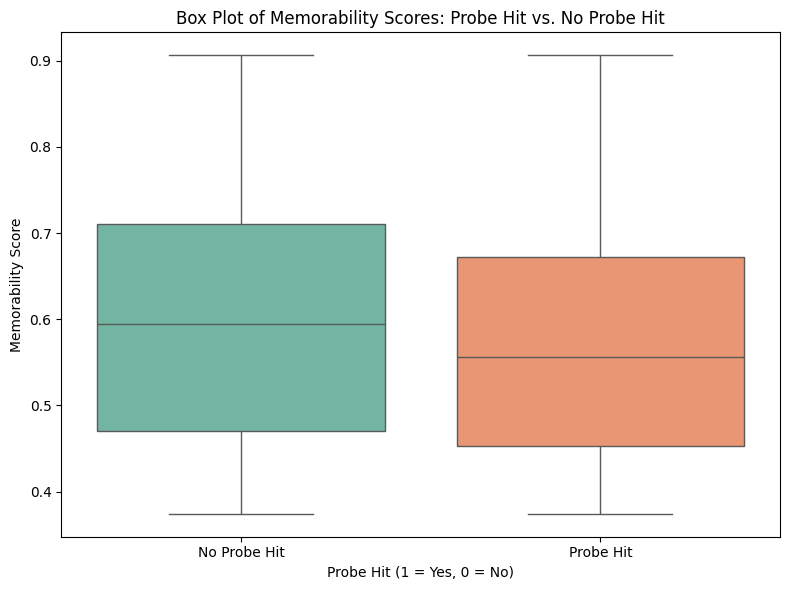

In [ ]:
# Initialize an empty list to store results
results = []

# Iterate over each unique participant ID
for subj_ID in target_table['observation'].unique():
    curr_sub_df = target_table[target_table['observation'] == subj_ID].copy()
    curr_sub_df = curr_sub_df.sort_values('timestamp')

    no_img_indices = curr_sub_df[curr_sub_df['sender'] == 'Test_no_img'].index

    for idx in no_img_indices:
        img_block = curr_sub_df.loc[idx:idx]
        condition = img_block.iloc[0]['condition']

        if not isinstance(condition, str):
            continue

        img_trials = img_block[img_block['trial_type'] == 'YES']
        if img_trials.empty:
            continue

        probe_block = curr_sub_df[(curr_sub_df.index > idx) & (curr_sub_df['sender'] == 'Test_probe')]
        if probe_block.empty:
            continue

        probe_trial = probe_block.iloc[0]

        # Check if probe detection was correct
        probe_hit = ((probe_trial['is_probe'] == 'YES' and probe_trial['response'] == 'YES') or
                     (probe_trial['is_probe'] == 'NO' and probe_trial['response'] == 'NO'))

        # Find the closest row with sender == 'Target6' above the probe trial
        target6_row = curr_sub_df[(curr_sub_df.index < probe_trial.name) & (curr_sub_df['sender'] == 'Target6')].iloc[-1:]

        # If there is a valid 'Target6' row
        if not target6_row.empty:
            target6_value = target6_row.iloc[0]
            # Assuming that the memorability score is already in the table as 'Memorability' for that row
            mem_score = target6_value['Memorability']
            
            # Store the result with probe_hit and the memorability score
            results.append({
                'sub': subj_ID,
                'probe_hit': probe_hit,
                'mem_score': mem_score
            })



results_df['probe_hit'] = results_df['probe_hit'].astype(int)

# Calculate the average memorability score for each category (Probe Hit vs No Probe Hit)
mean_mem_score = results_df.groupby('probe_hit')['mem_score'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.boxplot(x='probe_hit', y='mem_score', data=results_df, palette='Set2')

plt.xlabel('Probe Hit (1 = Yes, 0 = No)')
plt.ylabel('Memorability Score')
plt.title('Box Plot of Memorability Scores: Probe Hit vs. No Probe Hit')

plt.xticks([0, 1], ['No Probe Hit', 'Probe Hit'])
plt.tight_layout()
plt.show()





/var/folders/f1/wkfpsl417m78r76gy_1p5hv80000gn/T/ipykernel_1413/1662342531.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  curr_ax.set_xticklabels(['34', '84', '167'])
/var/folders/f1/wkfpsl417m78r76gy_1p5hv80000gn/T/ipykernel_1413/1662342531.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  curr_ax.set_xticklabels(['34', '84', '167'])


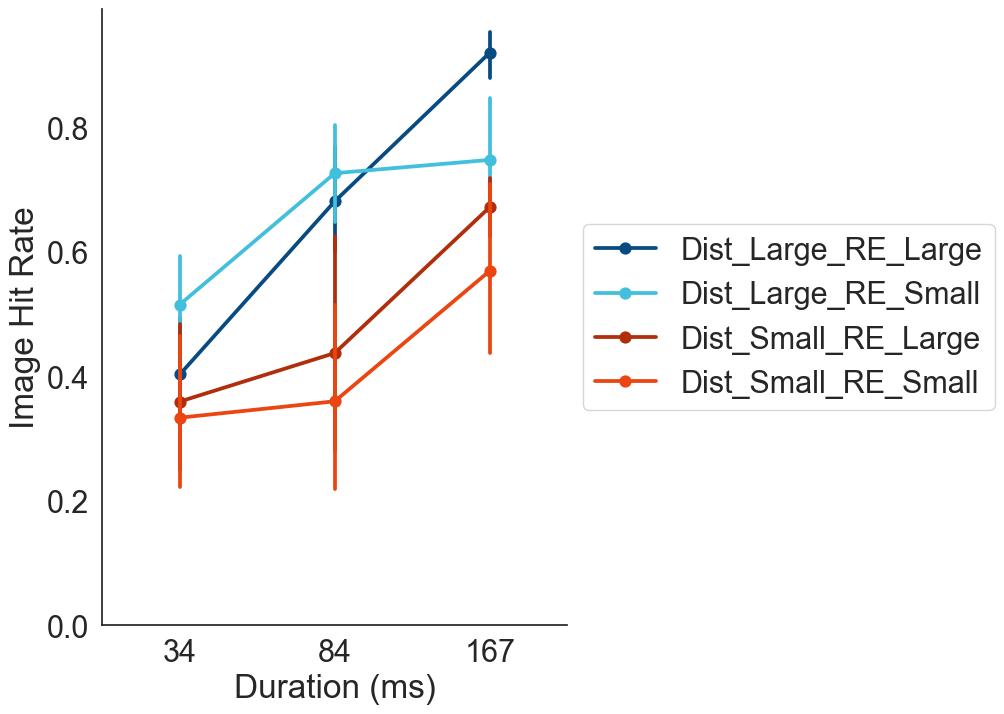

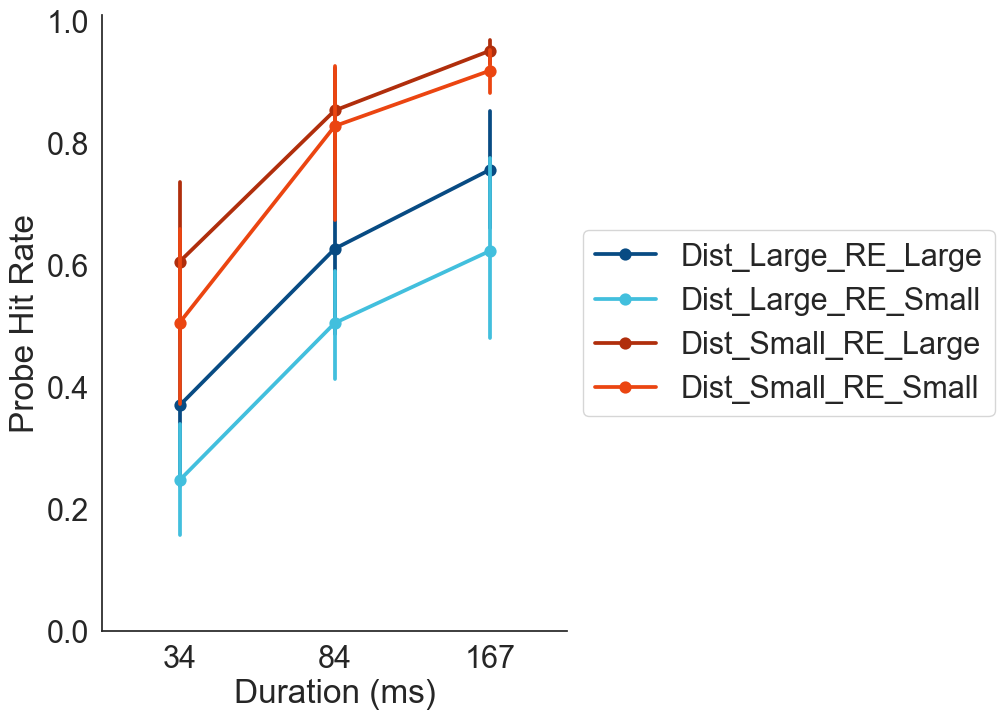

In [ ]:


# Step 1: Replace empty strings with NaN
performance_summary_targets['duration'] = performance_summary_targets['duration'].replace('', np.nan)

# Step 2: Convert to numeric
performance_summary_targets['duration'] = pd.to_numeric(performance_summary_targets['duration'], errors='coerce')

# Step 3: Apply mapping (including 2 → ?? if needed)
duration_map = {0: 34, 2: 50, 5: 84, 10: 167}  # You can decide what '2' should map to — I put 50 as an example
performance_summary_targets['duration'] = performance_summary_targets['duration'].replace(duration_map)


sns.set(font_scale=2)
sns.set_style('white')
plt.figure(figsize=(6,8))
curr_ax = sns.pointplot(x='duration', y='hit', hue='property', 
          palette=['#084B83', '#42BFDD', '#B02E0C', '#EB4511'],
           hue_order=['Dist_Large_RE_Large', 'Dist_Large_RE_Small',
                      'Dist_Small_RE_Large', 'Dist_Small_RE_Small'],
           data=performance_summary_targets)
sns.despine(top=True, right=True)
_, ymax = curr_ax.get_ylim()
curr_ax.set_ylabel('Image Hit Rate')
curr_ax.set_ylim([0, ymax])
curr_ax.set_xticklabels(['34', '84', '167'])
curr_ax.set_xlabel('Duration (ms)')

# Move legend
curr_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


sns.set(font_scale=2)
sns.set_style('white')
plt.figure(figsize=(6,8))
curr_ax = sns.pointplot(x='duration', y='probe_hit', hue='property', 
          palette=['#084B83', '#42BFDD', '#B02E0C', '#EB4511'],
           hue_order=['Dist_Large_RE_Large', 'Dist_Large_RE_Small',
                      'Dist_Small_RE_Large', 'Dist_Small_RE_Small'],
           data=performance_summary_targets)
sns.despine(top=True, right=True)
_, ymax = curr_ax.get_ylim()
curr_ax.set_ylabel('Probe Hit Rate')
curr_ax.set_ylim([0, ymax])
curr_ax.set_xticklabels(['34', '84', '167'])
curr_ax.set_xlabel('Duration (ms)')

# Move legend
curr_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



Unequal lengths for probe hit and no probe hit, cannot perform paired t-test.


/var/folders/f1/wkfpsl417m78r76gy_1p5hv80000gn/T/ipykernel_2116/1122394847.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='probe_hit', y='mem_score', data=results_df, palette='Set2')


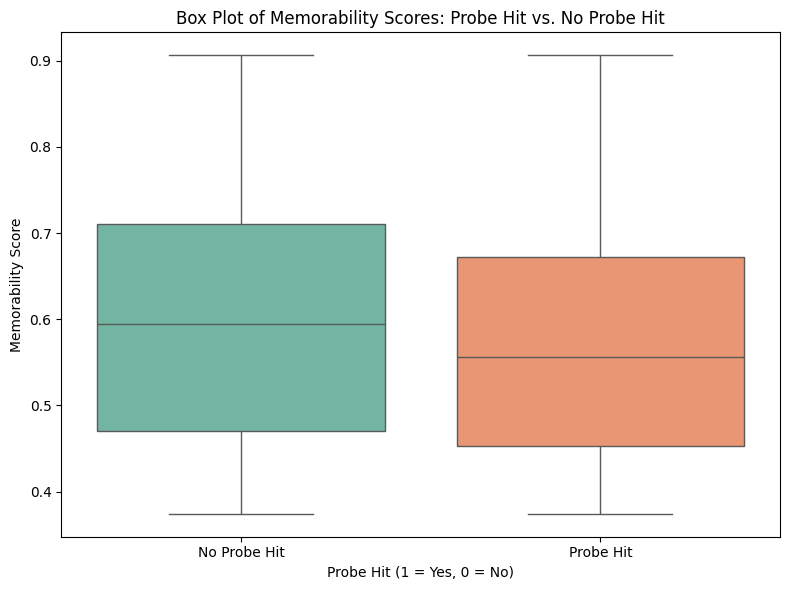

   probe_hit  mem_score
0          0   0.600921
1          1   0.572284


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

# Initialize an empty list to store results
results = []

# Iterate over each unique participant ID
for subj_ID in target_table['observation'].unique():
    curr_sub_df = target_table[target_table['observation'] == subj_ID].copy()
    curr_sub_df = curr_sub_df.sort_values('timestamp')

    no_img_indices = curr_sub_df[curr_sub_df['sender'] == 'Test_no_img'].index

    for idx in no_img_indices:
        img_block = curr_sub_df.loc[idx:idx]
        condition = img_block.iloc[0]['condition']

        if not isinstance(condition, str):
            continue

        img_trials = img_block[img_block['trial_type'] == 'YES']
        if img_trials.empty:
            continue

        probe_block = curr_sub_df[(curr_sub_df.index > idx) & (curr_sub_df['sender'] == 'Test_probe')]
        if probe_block.empty:
            continue

        probe_trial = probe_block.iloc[0]

        # Check if probe detection was correct
        probe_hit = ((probe_trial['is_probe'] == 'YES' and probe_trial['response'] == 'YES') or
                     (probe_trial['is_probe'] == 'NO' and probe_trial['response'] == 'NO'))

        # Find the closest row with sender == 'Target6' above the probe trial
        target6_row = curr_sub_df[(curr_sub_df.index < probe_trial.name) & (curr_sub_df['sender'] == 'Target6')].iloc[-1:]

        # If there is a valid 'Target6' row
        if not target6_row.empty:
            target6_value = target6_row.iloc[0]
            # Assuming that the memorability score is already in the table as 'Memorability' for that row
            mem_score = target6_value['Memorability']
            
            # Store the result with probe_hit and the memorability score
            results.append({
                'sub': subj_ID,
                'probe_hit': probe_hit,
                'mem_score': mem_score
            })

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Convert 'probe_hit' to integer for clarity (1 for probe hit, 0 for no probe hit)
results_df['probe_hit'] = results_df['probe_hit'].astype(int)

# Ensure that we have data for both probe hit (1) and no probe hit (0) for each subject
# Remove subjects that have only one of the two conditions (i.e., no probe hit or no probe miss)

results_df = results_df.groupby('sub').filter(lambda x: len(x['probe_hit'].unique()) > 1)

# Perform t-test comparing memorability score for probe hits vs no probe hits
correct_probe_mem = results_df[results_df['probe_hit'] == 1]['mem_score']
incorrect_probe_mem = results_df[results_df['probe_hit'] == 0]['mem_score']

# Perform paired t-test for correct vs incorrect probe detection if both groups are of the same length
if len(correct_probe_mem) == len(incorrect_probe_mem):
    t_stat, p_value = ttest_rel(correct_probe_mem, incorrect_probe_mem)

    print(f"T-test results (Probe Hit vs. No Probe Hit):")
    print(f"t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")
else:
    print("Unequal lengths for probe hit and no probe hit, cannot perform paired t-test.")

# Plot a boxplot comparing memorability scores for probe hit vs no probe hit
plt.figure(figsize=(8, 6))
sns.boxplot(x='probe_hit', y='mem_score', data=results_df, palette='Set2')

plt.xlabel('Probe Hit (1 = Yes, 0 = No)')
plt.ylabel('Memorability Score')
plt.title('Box Plot of Memorability Scores: Probe Hit vs. No Probe Hit')

plt.xticks([0, 1], ['No Probe Hit', 'Probe Hit'])
plt.tight_layout()
plt.show()

# Optionally, display the average memorability score for each condition
mean_mem_score = results_df.groupby('probe_hit')['mem_score'].mean().reset_index()
print(mean_mem_score)


/Users/sarahcook/Downloads/SarahCook_NSCI_479_Task/RSVP_Exp/data/utils.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_sub_df['condition'] = curr_sub_df['condition'].fillna('').astype(str)
/Users/sarahcook/Downloads/SarahCook_NSCI_479_Task/RSVP_Exp/data/utils.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_sub_df['condition'] = curr_sub_df['condition'].fillna('').astype(str)
/Users/sarahcook/Downloads/SarahCook_NSCI_479_Task/RSVP_Exp/data/utils.py:173: SettingWithCopyWarning: 
A value 

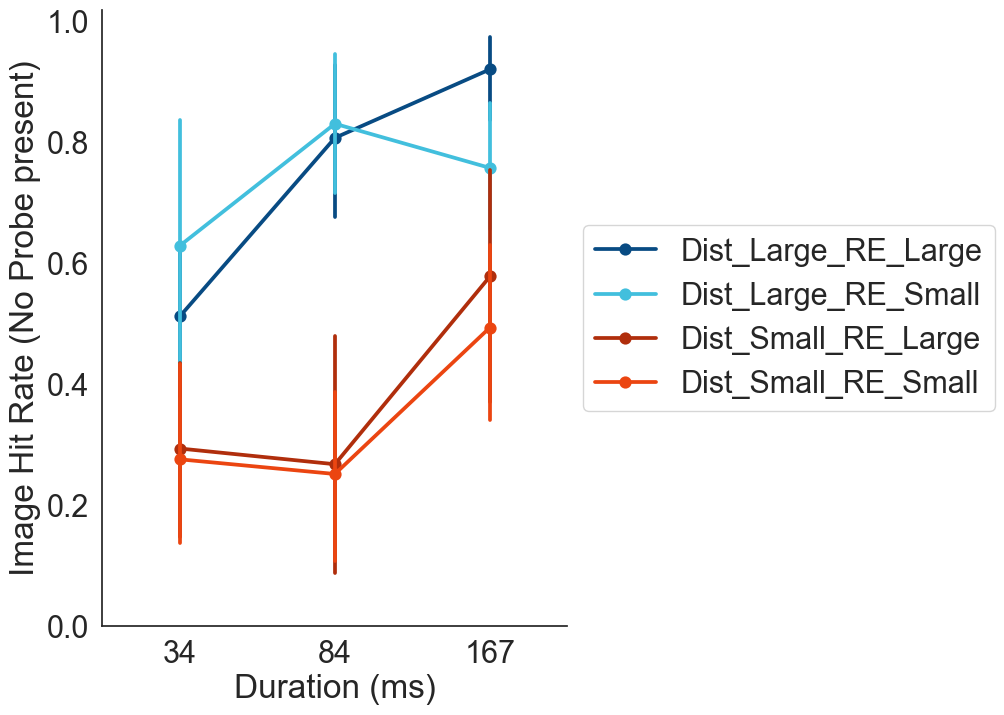

In [ ]:
performance_summary_noprobe = calc_performance_target_group_noprobe(subs_responses, subs_to_lookat)

import numpy as np

# Step 1: Replace empty strings with NaN
performance_summary_noprobe['duration'] = performance_summary_noprobe['duration'].replace('', np.nan)

# Step 2: Convert to numeric
performance_summary_noprobe['duration'] = pd.to_numeric(performance_summary_noprobe['duration'], errors='coerce')

# Step 3: Apply mapping (including 2 → ?? if needed)
duration_map = {0: 34, 2: 50, 5: 84, 10: 167}  # You can decide what '2' should map to — I put 50 as an example
performance_summary_noprobe['duration'] = performance_summary_noprobe['duration'].replace(duration_map)


sns.set(font_scale=2)
sns.set_style('white')
plt.figure(figsize=(6,8))
curr_ax = sns.pointplot(x='duration', y='hit', hue='property', 
          palette=['#084B83', '#42BFDD', '#B02E0C', '#EB4511'],
           hue_order=['Dist_Large_RE_Large', 'Dist_Large_RE_Small',
                      'Dist_Small_RE_Large', 'Dist_Small_RE_Small'],
           data=performance_summary_noprobe)
sns.despine(top=True, right=True)
_, ymax = curr_ax.get_ylim()
curr_ax.set_ylabel('Image Hit Rate (No Probe present)')
curr_ax.set_ylim([0, ymax])
curr_ax.set_xticklabels(['34', '84', '167'])
curr_ax.set_xlabel('Duration (ms)')

# Move legend
curr_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



/Users/sarahcook/Downloads/SarahCook_NSCI_479_Task/RSVP_Exp/data/utils.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_sub_df['condition'] = curr_sub_df['condition'].fillna('').astype(str)
/Users/sarahcook/Downloads/SarahCook_NSCI_479_Task/RSVP_Exp/data/utils.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_sub_df['condition'] = curr_sub_df['condition'].fillna('').astype(str)
/Users/sarahcook/Downloads/SarahCook_NSCI_479_Task/RSVP_Exp/data/utils.py:173: SettingWithCopyWarning: 
A value 

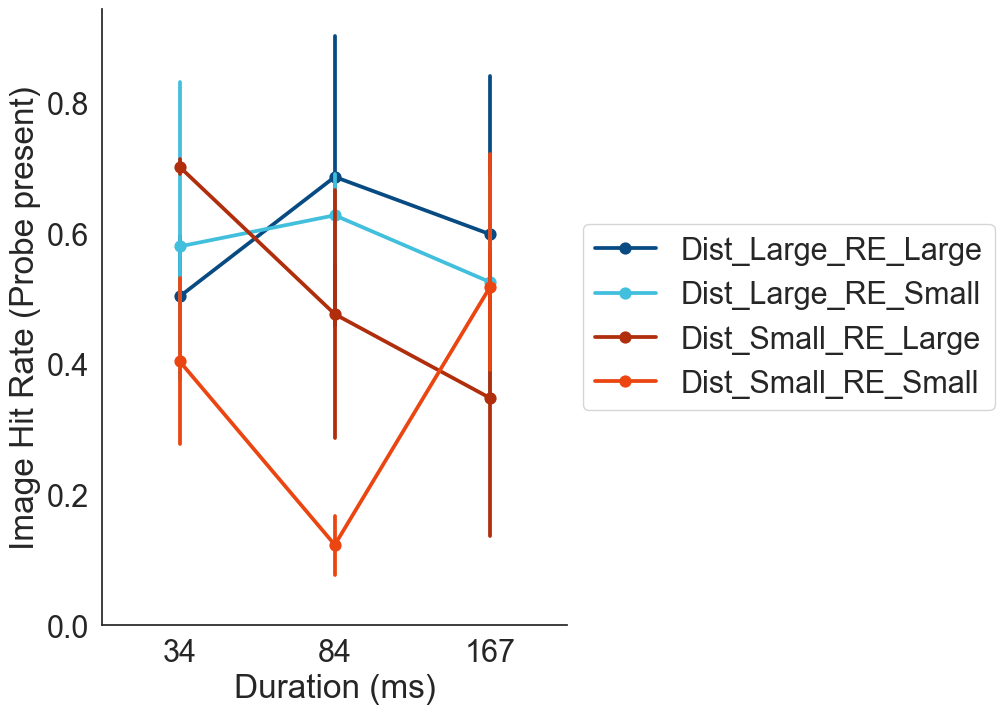

In [ ]:
performance_summary_yesprobe = calc_performance_target_group_yesprobe(subs_responses, subs_to_lookat)

import numpy as np

# Step 1: Replace empty strings with NaN
performance_summary_yesprobe['duration'] = performance_summary_noprobe['duration'].replace('', np.nan)

# Step 2: Convert to numeric
performance_summary_yesprobe['duration'] = pd.to_numeric(performance_summary_yesprobe['duration'], errors='coerce')

# Step 3: Apply mapping (including 2 → ?? if needed)
duration_map = {0: 34, 2: 50, 5: 84, 10: 167}  # You can decide what '2' should map to — I put 50 as an example
performance_summary_yesprobe['duration'] = performance_summary_yesprobe['duration'].replace(duration_map)


sns.set(font_scale=2)
sns.set_style('white')
plt.figure(figsize=(6,8))
curr_ax = sns.pointplot(x='duration', y='hit', hue='property', 
          palette=['#084B83', '#42BFDD', '#B02E0C', '#EB4511'],
           hue_order=['Dist_Large_RE_Large', 'Dist_Large_RE_Small',
                      'Dist_Small_RE_Large', 'Dist_Small_RE_Small'],
           data=performance_summary_yesprobe)
sns.despine(top=True, right=True)
_, ymax = curr_ax.get_ylim()
curr_ax.set_ylabel('Image Hit Rate (Probe present)')
curr_ax.set_ylim([0, ymax])
curr_ax.set_xticklabels(['34', '84', '167'])
curr_ax.set_xlabel('Duration (ms)')

# Move legend
curr_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


Now generate the data file for running ANOVA in R. 

/var/folders/f1/wkfpsl417m78r76gy_1p5hv80000gn/T/ipykernel_1413/2122422067.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=condition_data, x='category', order=category_order, palette=palette)


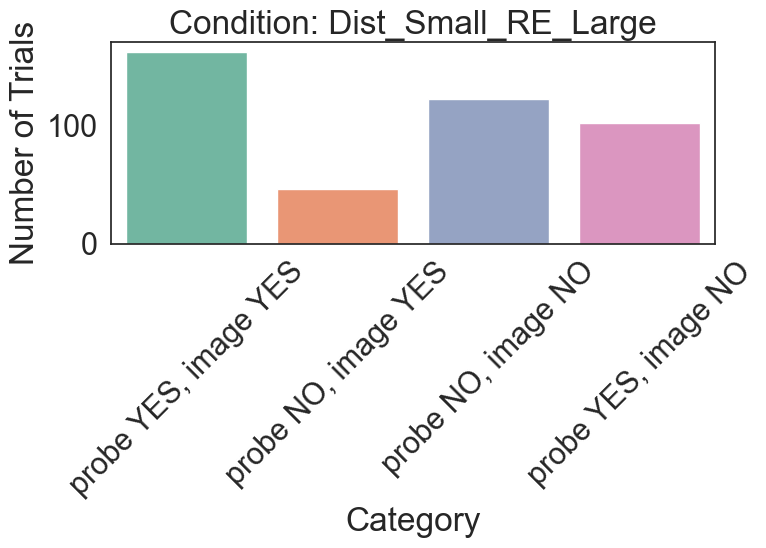

/var/folders/f1/wkfpsl417m78r76gy_1p5hv80000gn/T/ipykernel_1413/2122422067.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=condition_data, x='category', order=category_order, palette=palette)


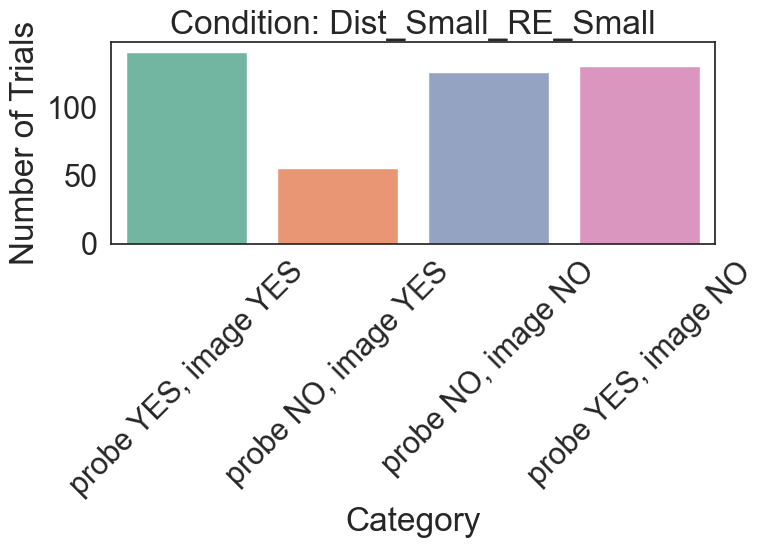

/var/folders/f1/wkfpsl417m78r76gy_1p5hv80000gn/T/ipykernel_1413/2122422067.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=condition_data, x='category', order=category_order, palette=palette)


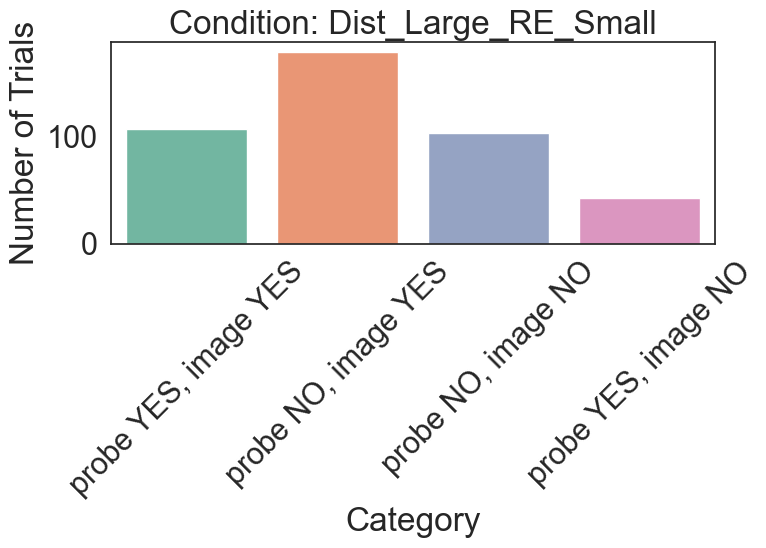

/var/folders/f1/wkfpsl417m78r76gy_1p5hv80000gn/T/ipykernel_1413/2122422067.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=condition_data, x='category', order=category_order, palette=palette)


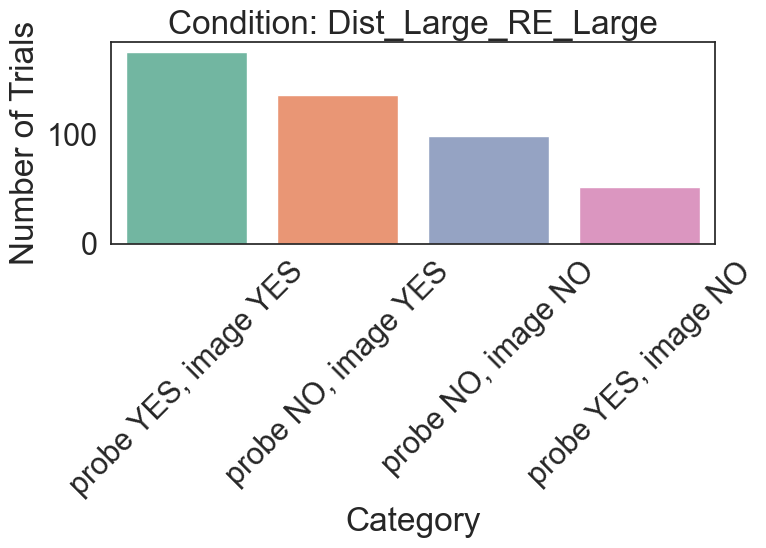

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'subs_responses' is already loaded
# Example: subs_responses = pd.read_csv('/path/to/your/data.csv')

# Initialize an empty list to store results
results = []

# Iterate over each unique participant ID
for subj_ID in subs_responses['observation'].unique():
    # Extract data for the current participant
    curr_sub_df = subs_responses[subs_responses['observation'] == subj_ID].copy()
    curr_sub_df = curr_sub_df.sort_values('timestamp')  # Ensure trials are in chronological order

    # Get all 'Test_no_img' block indices
    no_img_indices = curr_sub_df[curr_sub_df['sender'] == 'Test_no_img'].index

    for idx in no_img_indices:
        # Get the 'Test_no_img' block trial (this assumes only one 'Test_no_img' per sequence)
        img_block = curr_sub_df.loc[idx:idx]  # Currently just one row, but you may need to adjust for more complex blocks
        duration = img_block.iloc[0]['duration']
        condition = img_block.iloc[0]['condition']

        # Get only trials where image response is 'YES' (image trials)
        img_trials = img_block[img_block['trial_type'] == 'YES']

        # If there are no valid image trials, skip this block
        if img_trials.empty:
            continue

        # Calculate image hit and false alarm rates for the image trials
        img_hit = np.round(np.sum(img_trials['response'] == 'YES') / len(img_trials), 3) if len(img_trials) > 0 else np.nan
        img_fa = np.round(np.sum(img_trials['response'] == 'NO') / len(img_trials), 3) if len(img_trials) > 0 else np.nan

        # Find the corresponding 'Test_probe' block (ensure it's paired with 'Test_no_img')
        probe_block = curr_sub_df[(curr_sub_df.index > idx) & (curr_sub_df['sender'] == 'Test_probe')]
        if probe_block.empty:
            continue  # Skip if there's no corresponding probe block

        # Get the first matching probe trial
        probe_trial = probe_block.iloc[0]

        # Check if the probe response is 'YES' or 'NO'
        probe_hit = np.sum(probe_trial['response'] == 'YES') > 0  # True if 'YES' response
        probe_fa = np.sum(probe_trial['response'] == 'NO') > 0  # True if 'NO' response

        # Categorize trial combinations
        if probe_hit and img_hit:
            category = 'probe YES, image YES'
        elif not probe_hit and img_hit:
            category = 'probe NO, image YES'
        elif not probe_hit and not img_hit:
            category = 'probe NO, image NO'
        elif probe_hit and not img_hit:
            category = 'probe YES, image NO'

        # Store results for each trial
        results.append({
            'sub': subj_ID,
            'duration': duration,
            'condition': condition,
            'category': category
        })

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Clean condition names by extracting the main part (e.g., remove numbers and extra parts)
results_df['condition_clean'] = results_df['condition'].str.extract(r'(Dist_[A-Za-z]+_RE_[A-Za-z]+)')[0]

# Now we should have only the base condition names without suffixes
# Get the unique conditions
conditions = results_df['condition_clean'].dropna().unique()

# Make sure we only have 4 conditions
conditions = ['Dist_Small_RE_Large', 'Dist_Small_RE_Small', 'Dist_Large_RE_Small', 'Dist_Large_RE_Large']

# Set up the color palette for categories
category_order = ['probe YES, image YES', 'probe NO, image YES', 'probe NO, image NO', 'probe YES, image NO']
palette = sns.color_palette("Set2", len(category_order))

# Iterate over each condition and create a separate figure for it
for condition in conditions:
    # Filter results for the current condition
    condition_data = results_df[results_df['condition_clean'] == condition]
    
    # Create a new figure for each condition
    plt.figure(figsize=(8, 6))
    
    # Plot the bar graph for the current condition
    sns.countplot(data=condition_data, x='category', order=category_order, palette=palette)
    
    # Set the title and labels
    plt.title(f'Condition: {condition}')
    plt.xlabel('Category')
    plt.ylabel('Number of Trials')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    
    # Adjust layout to provide more space for the y-axis label
    plt.tight_layout()
    plt.subplots_adjust(left=0.15)  # Adjust left margin for the y-axis label
    
    # Show the plot
    plt.show()




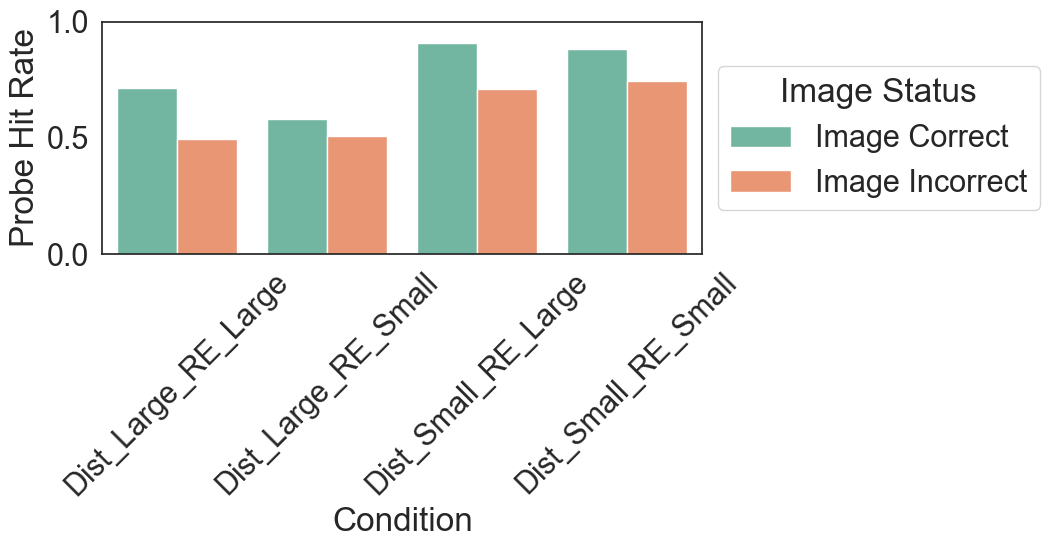

In [ ]:

results = []

for subj_ID in subs_responses['observation'].unique():
    curr_sub_df = subs_responses[subs_responses['observation'] == subj_ID].copy()
    curr_sub_df = curr_sub_df.sort_values('timestamp')

    no_img_indices = curr_sub_df[curr_sub_df['sender'] == 'Test_no_img'].index

    for idx in no_img_indices:
        img_block = curr_sub_df.loc[idx:idx]
        condition = img_block.iloc[0]['condition']

        img_trials = img_block[img_block['trial_type'] == 'YES']

        if img_trials.empty:
            continue

        # Check if the image trial was a hit (response matches trial_type)
        img_hit = np.sum(img_trials['response'] == img_trials['trial_type']) > 0
        img_status = 'Image Correct' if img_hit else 'Image Incorrect'

        # Find the corresponding probe block
        probe_block = curr_sub_df[(curr_sub_df.index > idx) & (curr_sub_df['sender'] == 'Test_probe')]
        if probe_block.empty:
            continue

        probe_trial = probe_block.iloc[0]

        is_probe = probe_trial['is_probe']  # 'YES' or 'NO'
        probe_response = probe_trial['response']  # 'YES' or 'NO'

        # Check if the probe detection was correct
        probe_correct = ((is_probe == 'YES' and probe_response == 'YES') or
                         (is_probe == 'NO' and probe_response == 'NO'))

        results.append({
            'sub': subj_ID,
            'condition': condition,
            'image_status': img_status,
            'probe_correct': probe_correct
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Clean condition names
results_df['condition_clean'] = results_df['condition'].str.extract(r'(Dist_[A-Za-z]+_RE_[A-Za-z]+)')[0]

# Summarize total trials and correct trials
summary_df = results_df.groupby(['condition_clean', 'image_status']).agg(
    total_trials=('probe_correct', 'count'),
    correct_trials=('probe_correct', 'sum')
).reset_index()

# Compute proportion correct
summary_df['proportion_correct'] = summary_df['correct_trials'] / summary_df['total_trials']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x='condition_clean', y='proportion_correct', hue='image_status', palette='Set2')


plt.xlabel('Condition')
plt.ylabel('Probe Hit Rate')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Move legend to the right
plt.legend(title='Image Status', loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust margins
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8)

plt.show()



Dist_Large_RE_Large - Image Correct vs Image Incorrect:
t = 1.454, p = 0.161
Dist_Small_RE_Small - Image Correct vs Image Incorrect:
t = 4.308, p = 0.000
Dist_Large_RE_Small - Image Correct vs Image Incorrect:
t = 1.432, p = 0.171
Dist_Small_RE_Large - Image Correct vs Image Incorrect:
t = 3.869, p = 0.001


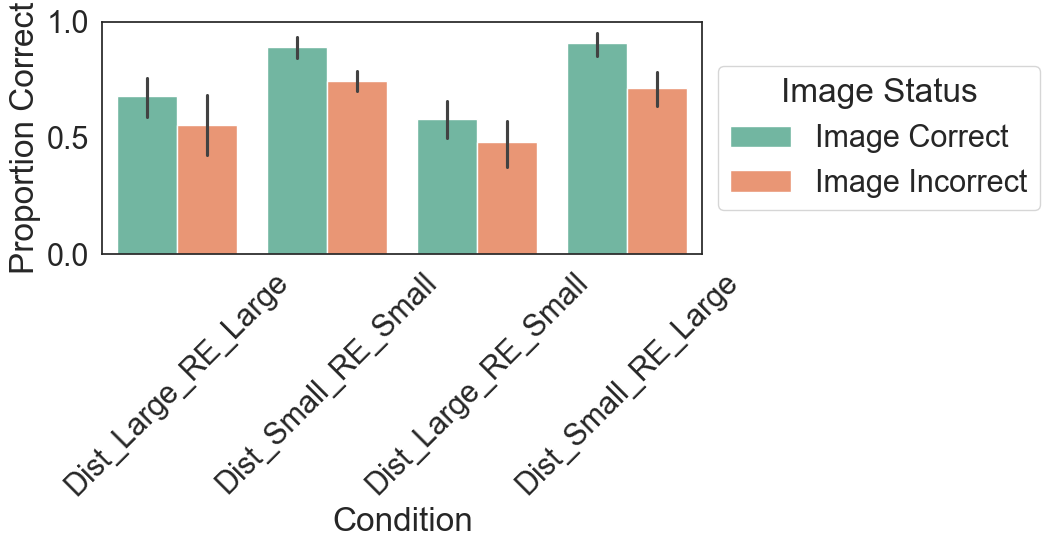

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

results = []

# Iterate over each unique participant ID
for subj_ID in subs_responses['observation'].unique():
    curr_sub_df = subs_responses[subs_responses['observation'] == subj_ID].copy()
    curr_sub_df = curr_sub_df.sort_values('timestamp')  # Ensure chronological order

    # Get all 'Test_no_img' block indices
    no_img_indices = curr_sub_df[curr_sub_df['sender'] == 'Test_no_img'].index

    for idx in no_img_indices:
        img_block = curr_sub_df.loc[idx:idx]  # Get the 'Test_no_img' block
        condition = img_block.iloc[0]['condition']

        # Get image trials (where 'trial_type' is 'YES')
        img_trials = img_block[img_block['trial_type'] == 'YES']

        if img_trials.empty:
            continue  # Skip if no image trials

        # Check if the image trial was a hit (response matches trial_type)
        img_hit = np.sum(img_trials['response'] == img_trials['trial_type']) > 0
        img_status = 'Image Correct' if img_hit else 'Image Incorrect'

        # Find the corresponding probe block
        probe_block = curr_sub_df[(curr_sub_df.index > idx) & (curr_sub_df['sender'] == 'Test_probe')]
        if probe_block.empty:
            continue  # Skip if no corresponding probe block

        probe_trial = probe_block.iloc[0]

        # Check if the probe detection was correct
        is_probe = probe_trial['is_probe']  # 'YES' or 'NO'
        probe_response = probe_trial['response']  # 'YES' or 'NO'

        probe_correct = ((is_probe == 'YES' and probe_response == 'YES') or
                         (is_probe == 'NO' and probe_response == 'NO'))

        # Append the results for each subject
        results.append({
            'sub': subj_ID,
            'condition': condition,
            'image_status': img_status,
            'probe_correct': probe_correct
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Clean condition names
results_df['condition_clean'] = results_df['condition'].str.extract(r'(Dist_[A-Za-z]+_RE_[A-Za-z]+)')[0]

# Summarize total trials and correct trials per subject
subject_summary_df = results_df.groupby(['sub', 'condition_clean', 'image_status']).agg(
    total_trials=('probe_correct', 'count'),
    correct_trials=('probe_correct', 'sum')
).reset_index()

# Compute proportion correct for each subject
subject_summary_df['proportion_correct'] = subject_summary_df['correct_trials'] / subject_summary_df['total_trials']

# Now, we can perform a t-test for each condition comparing 'Image Correct' vs 'Image Incorrect' for each subject
conditions = subject_summary_df['condition_clean'].unique()

for condition in conditions:
    # Get the proportion correct for 'Image Correct' and 'Image Incorrect' for each subject
    present_group = subject_summary_df[(subject_summary_df['condition_clean'] == condition) & (subject_summary_df['image_status'] == 'Image Correct')]
    absent_group = subject_summary_df[(subject_summary_df['condition_clean'] == condition) & (subject_summary_df['image_status'] == 'Image Incorrect')]

    # Perform the t-test
    t_stat, p_value = ttest_ind(present_group['proportion_correct'], absent_group['proportion_correct'])
    
    # Output the result
    print(f"{condition} - Image Correct vs Image Incorrect:")
    print(f"t = {t_stat:.3f}, p = {p_value:.3f}")

# Optional: Visualize the results with a barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=subject_summary_df, x='condition_clean', y='proportion_correct', hue='image_status', palette='Set2')

plt.xlabel('Condition')
plt.ylabel('Proportion Correct')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Move legend to the right
plt.legend(title='Image Status', loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust margins
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8)

plt.show()



In [ ]:
performance_summary_targets.to_csv(os.path.join(paper_data_dir,'Summary_targets.csv'))
print(performance_summary_targets.duration)

0        NaN
1      167.0
2      167.0
3       84.0
4       50.0
       ...  
221    167.0
222     84.0
223    167.0
224    167.0
225     84.0
Name: duration, Length: 226, dtype: float64


T-test results (HIGH RE vs. LOW RE):
t = 1.649, p = 0.134


/var/folders/f1/wkfpsl417m78r76gy_1p5hv80000gn/T/ipykernel_1413/845211261.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_df, x='re_category', y='probe_hit', palette='Set2')


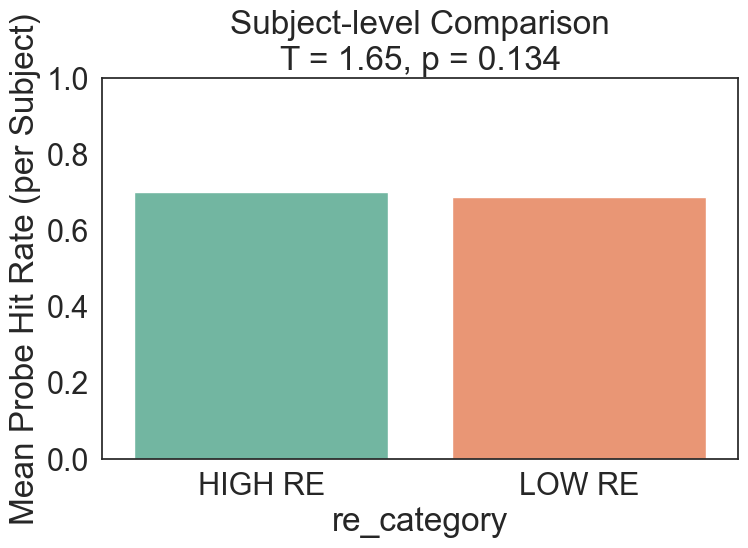

In [ ]:
from scipy.stats import ttest_rel


# Initialize an empty list to store results
results = []

# Iterate over each unique participant ID
for subj_ID in subs_responses['observation'].unique():
    curr_sub_df = subs_responses[subs_responses['observation'] == subj_ID].copy()
    curr_sub_df = curr_sub_df.sort_values('timestamp')

    no_img_indices = curr_sub_df[curr_sub_df['sender'] == 'Test_no_img'].index

    for idx in no_img_indices:
        img_block = curr_sub_df.loc[idx:idx]
        condition = img_block.iloc[0]['condition']

        if not isinstance(condition, str):
            continue

        img_trials = img_block[img_block['trial_type'] == 'YES']
        if img_trials.empty:
            continue

        probe_block = curr_sub_df[(curr_sub_df.index > idx) & (curr_sub_df['sender'] == 'Test_probe')]
        if probe_block.empty:
            continue

        probe_trial = probe_block.iloc[0]

        # FIXED: determine if probe detection was correct
        probe_hit = ((probe_trial['is_probe'] == 'YES' and probe_trial['response'] == 'YES') or
                     (probe_trial['is_probe'] == 'NO' and probe_trial['response'] == 'NO'))

        # Determine RE category
        if 'RE_Large' in condition:
            re_category = 'HIGH RE'
        elif 'RE_Small' in condition:
            re_category = 'LOW RE'
        else:
            continue

        results.append({
            'sub': subj_ID,
            're_category': re_category,
            'probe_hit': probe_hit
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.dropna(subset=['probe_hit'])

# Subject-level aggregation
subject_summary_df = results_df.groupby(['sub', 're_category'])['probe_hit'].mean().reset_index()

# Pivot to get one row per subject with HIGH and LOW RE side-by-side
subject_pivot = subject_summary_df.pivot(index='sub', columns='re_category', values='probe_hit').dropna()

# Perform t-test across subjects (independent since it's between groups)
if 'HIGH RE' in subject_pivot.columns and 'LOW RE' in subject_pivot.columns:
    t_stat, p_value = ttest_rel(subject_pivot['HIGH RE'], subject_pivot['LOW RE'])

    print(f"T-test results (HIGH RE vs. LOW RE):")
    print(f"t = {t_stat:.3f}, p = {p_value:.3f}")

    # Plot bar graph using subject-level means
    mean_df = subject_summary_df.groupby('re_category')['probe_hit'].mean().reset_index()

    plt.figure(figsize=(8, 6))
    sns.barplot(data=mean_df, x='re_category', y='probe_hit', palette='Set2')
    plt.ylabel('Mean Probe Hit Rate (per Subject)')
    plt.ylim(0, 1)
    plt.title(f"Subject-level Comparison\nT = {t_stat:.2f}, p = {p_value:.3f}")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to perform t-test: missing HIGH RE or LOW RE.")
         

In [ ]:
performance_summary_all = calc_performance_group(subs_responses, subs_to_lookat)
# Make sure that all the participants have above-chance performance overall (dprime > 0)
assert np.all(performance_summary_all[performance_summary_all['duration']=='all']['dprime']>0)


performance_summary_targets = calc_performance_target_group(subs_responses, subs_to_lookat)
performance_summary_targets['duration'] = pd.to_numeric(
    performance_summary_targets['duration'], errors='coerce'
)

print(performance_summary_targets.columns)

# Set the number of bootstrapping iterations
n_iter = 1000

# Use tqdm with range for iteration (without any notebook dependency)
for curr_iter in tqdm(range(n_iter)):
    # Bootstrapping logic here
    pass


large_dist_early = performance_summary_targets[(performance_summary_targets['Dist']=='Large')&
                                          (performance_summary_targets['duration']!=10)]
large_dist_early_results = run_bootstrapping(large_dist_early, subs_to_lookat)
tmp_df = pd.DataFrame(large_dist_early_results, columns=['Beta_diff'])
tmp_df['Dist'] = 'Large'
tmp_df['Stage'] = 'Early'
all_bootstrap_results = tmp_df

small_dist_early = performance_summary_targets[(performance_summary_targets['Dist']=='Small')&
                                          (performance_summary_targets['duration']!=10)]
small_dist_early_results = run_bootstrapping(small_dist_early, subs_to_lookat)
tmp_df = pd.DataFrame(small_dist_early_results, columns=['Beta_diff'])
tmp_df['Dist'] = 'Small'
tmp_df['Stage'] = 'Early'
all_bootstrap_results = all_bootstrap_results.append(tmp_df)

large_dist_late = performance_summary_targets[(performance_summary_targets['Dist']=='Large')&
                                          (performance_summary_targets['duration']!=2)]
large_dist_late_results = run_bootstrapping(large_dist_late, subs_to_lookat)
tmp_df = pd.DataFrame(large_dist_late_results, columns=['Beta_diff'])
tmp_df['Dist'] = 'Large'
tmp_df['Stage'] = 'Late'
all_bootstrap_results = all_bootstrap_results.append(tmp_df)

small_dist_late = performance_summary_targets[(performance_summary_targets['Dist']=='Small')&
                                          (performance_summary_targets['duration']!=2)]
small_dist_late_results = run_bootstrapping(small_dist_late, subs_to_lookat)
tmp_df = pd.DataFrame(small_dist_late_results, columns=['Beta_diff'])
tmp_df['Dist'] = 'Small'
tmp_df['Stage'] = 'Late'
all_bootstrap_results = all_bootstrap_results.append(tmp_df)

/Users/sarahcook/Downloads/SarahCook_NSCI_479_Task/RSVP_Exp/data/utils.py:56: RuntimeWarning: invalid value encountered in scalar subtract
  img_dprime = np.round(norm.ppf(img_hit) - norm.ppf(img_fa), 3)
/Users/sarahcook/Downloads/SarahCook_NSCI_479_Task/RSVP_Exp/data/utils.py:98: RuntimeWarning: invalid value encountered in scalar subtract
  probe_dprime = np.round(norm.ppf(probe_hit) - norm.ppf(probe_fa), 3)
/Users/sarahcook/Downloads/SarahCook_NSCI_479_Task/RSVP_Exp/data/utils.py:98: RuntimeWarning: invalid value encountered in scalar subtract
  probe_dprime = np.round(norm.ppf(probe_hit) - norm.ppf(probe_fa), 3)
/Users/sarahcook/Downloads/SarahCook_NSCI_479_Task/RSVP_Exp/data/utils.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_su

Index(['sub', 'condition', 'hit', 'fa', 'dprime', 'response_type', 'probe_hit',
       'probe_fa', 'probe_dprime', 'duration', 'property', 'Dist', 'RE'],
      dtype='object')


100%|██████████| 1000/1000 [00:00<00:00, 4629474.61it/s]


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

                                     sub distinct_category  probe_hit_rate
0   a809a141-4862-4ef9-9206-d64dc894c78f     HIGH DISTINCT        0.531250
1   a809a141-4862-4ef9-9206-d64dc894c78f      LOW DISTINCT        0.864583
2   17a0b95a-caef-46b5-afdd-2ee194101fff     HIGH DISTINCT        0.770833
3   17a0b95a-caef-46b5-afdd-2ee194101fff      LOW DISTINCT        0.789474
4   f8655bf3-bf42-497a-9702-1b335456b7de     HIGH DISTINCT        0.500000
5   fee306a7-c87d-4874-98a7-c3b90159186d     HIGH DISTINCT        0.739583
6   fee306a7-c87d-4874-98a7-c3b90159186d      LOW DISTINCT        0.833333
7   f6e87870-50ab-4b9c-b96b-e716fb583ae4     HIGH DISTINCT        0.541667
8   f6e87870-50ab-4b9c-b96b-e716fb583ae4      LOW DISTINCT        0.812500
9   c89203fd-8e26-4753-9bea-d04e3141df7e     HIGH DISTINCT        0.520833
10  c89203fd-8e26-4753-9bea-d04e3141df7e      LOW DISTINCT        0.770833
11  a6af2a1e-3ffc-4337-a0e7-33fd28d45dc6     HIGH DISTINCT        0.625000
12  a6af2a1e-3ffc-4337-a0

/var/folders/f1/wkfpsl417m78r76gy_1p5hv80000gn/T/ipykernel_1413/1713490793.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_df, x='distinct_category', y='probe_hit_rate', palette='Set2')


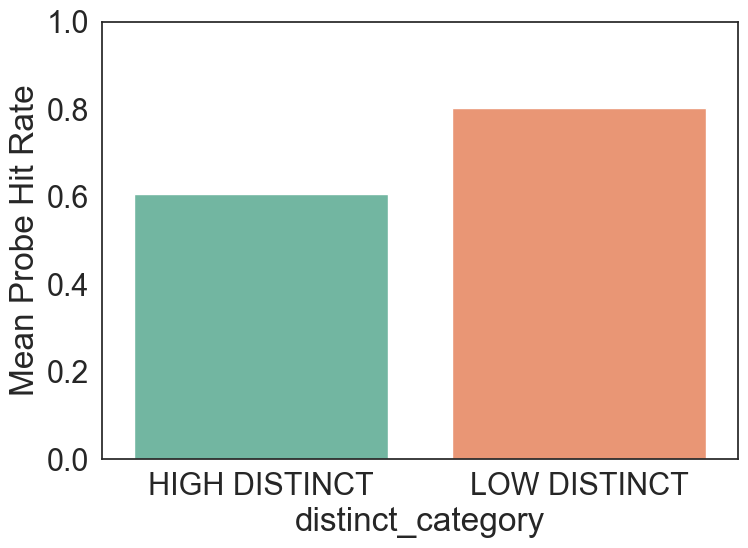

In [ ]:
from scipy.stats import ttest_rel


# Initialize an empty list to store all trial records
trial_records = []

# Iterate over each participant
for subj_ID in subs_responses['observation'].unique():
    # Initialize counters per subject
    counts = {
        'HIGH DISTINCT': {'correct': 0, 'total': 0},
        'LOW DISTINCT': {'correct': 0, 'total': 0}
    }

    curr_sub_df = subs_responses[subs_responses['observation'] == subj_ID].copy()
    curr_sub_df = curr_sub_df.sort_values('timestamp')

    no_img_indices = curr_sub_df[curr_sub_df['sender'] == 'Test_no_img'].index

    for idx in no_img_indices:
        img_block = curr_sub_df.loc[idx:idx]
        condition = img_block.iloc[0]['condition']

        if not isinstance(condition, str):
            continue

        # Assign distinctiveness category
        if 'Dist_Large' in condition:
            distinct_category = 'HIGH DISTINCT'
        elif 'Dist_Small' in condition:
            distinct_category = 'LOW DISTINCT'
        else:
            continue

        img_trials = img_block[img_block['trial_type'] == 'YES']
        if img_trials.empty:
            continue

        probe_block = curr_sub_df[(curr_sub_df.index > idx) & (curr_sub_df['sender'] == 'Test_probe')]
        if probe_block.empty:
            continue

        probe_trial = probe_block.iloc[0]

        is_probe_present = probe_trial['is_probe'] == 'YES'
        response_yes = probe_trial['response'] == 'YES'

        probe_correct = ((is_probe_present and response_yes) or 
                         (not is_probe_present and not response_yes))

        # Update total trials
        counts[distinct_category]['total'] += 1

        if probe_correct:
            counts[distinct_category]['correct'] += 1

    # Calculate hit rates normalized by maximum trial count
    max_high = counts['HIGH DISTINCT']['total']
    max_low = counts['LOW DISTINCT']['total']

    for cat in ['HIGH DISTINCT', 'LOW DISTINCT']:
        total_trials = counts[cat]['total']
        correct_hits = counts[cat]['correct']
        max_trials = max_high if cat == 'HIGH DISTINCT' else max_low

        if max_trials > 0:
            probe_hit_rate = correct_hits / max_trials
            trial_records.append({
                'sub': subj_ID,
                'distinct_category': cat,
                'probe_hit_rate': probe_hit_rate
            })

# Convert to DataFrame
trials_df = pd.DataFrame(trial_records)
print(trials_df)

# Pivot to get HIGH DISTINCT and LOW DISTINCT side-by-side
subject_pivot = trials_df.pivot(index='sub', columns='distinct_category', values='probe_hit_rate').dropna()
print(subject_pivot)

# Perform t-test across subjects
if 'HIGH DISTINCT' in subject_pivot.columns and 'LOW DISTINCT' in subject_pivot.columns:
    t_stat, p_value =  ttest_rel(subject_pivot['HIGH DISTINCT'], subject_pivot['LOW DISTINCT'])

    print(f"T-test results (HIGH DISTINCT vs. LOW DISTINCT):")
    print(f"t = {t_stat:.3f}, p = {p_value:.3f}")

    # Calculate mean probe hit rates across subjects for each category
    mean_df = subject_pivot.mean().reset_index()
    mean_df.columns = ['distinct_category', 'probe_hit_rate']

    plt.figure(figsize=(8, 6))
    sns.barplot(data=mean_df, x='distinct_category', y='probe_hit_rate', palette='Set2')
    plt.ylabel('Mean Probe Hit Rate')
    plt.ylim(0, 1)
   
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to perform t-test: missing HIGH DISTINCT or LOW DISTINCT.")


In [ ]:
all_bootstrap_results[(all_bootstrap_results['Dist']=='Large')&
                     (all_bootstrap_results['Stage']=='Early')]['Beta_diff'].mean()

np.sum(all_bootstrap_results[(all_bootstrap_results['Dist']=='Large')&
                     (all_bootstrap_results['Stage']=='Early')]['Beta_diff']<0)

all_bootstrap_results[(all_bootstrap_results['Dist']=='Small')&
                     (all_bootstrap_results['Stage']=='Late')]['Beta_diff'].mean()

np.sum(all_bootstrap_results[(all_bootstrap_results['Dist']=='Small')&
                     (all_bootstrap_results['Stage']=='Late')]['Beta_diff']<0)

plt.figure(figsize=(8,6))
curr_ax = sns.swarmplot(x='Dist',order=['Large','Small'], hue = 'Stage', hue_order=['Early', 'Late'],
                        y='Beta_diff', dodge=True,size=2,
                        data=all_bootstrap_results)

curr_ax.axhline(0, ls='--')
curr_ax.set_ylabel('\u0394 Slope')
curr_ax.set_xlabel('Distinctiveness')


stage_list = ['Early', 'Late']
xtick_labels = curr_ax.get_xticklabels()
  
for curr_xtick_ind, curr_xtick_label in enumerate(xtick_labels):

    for curr_stage_ind, curr_stage in enumerate(stage_list):
        curr_beta_diff = all_bootstrap_results[(all_bootstrap_results['Dist']==curr_xtick_label.get_text())&
                                       (all_bootstrap_results['Stage']==curr_stage)]['Beta_diff'].values

        curr_pval = np.sum(curr_beta_diff<0)/1000

        if curr_pval > 0.1:
            sign_label = 'n.s.'
        elif (curr_pval <= 0.1) and (curr_pval > 0.05):
            sign_label = '~'
        elif (curr_pval <= 0.05) and (curr_pval > 0.01):
            sign_label = '*'
        elif (curr_pval <= 0.01) and (curr_pval > 0.001):
            sign_label = '**'
        elif (curr_pval <= 0.001) :
            sign_label = '***'
        curr_x_pos = curr_xtick_ind+((curr_stage_ind-0.5)/0.5)*0.25

        curr_y_pos = np.max(curr_beta_diff)+0.01

        #curr_ax.text(curr_x_pos, curr_y_pos, 'mean = {}, \np={}'.format(np.mean(curr_beta_diff).round(2),curr_pval), horizontalalignment='center')
        curr_ax.text(curr_x_pos, curr_y_pos, '{}'.format(sign_label), horizontalalignment='center')
        
swarm_cols = curr_ax.collections

curr_df = all_bootstrap_results
N_cats = len(np.unique(curr_df.Dist))
N_hues = len(np.unique(curr_df.Stage))


face_colors = ['#ffffff',"#084B83","#ffffff",'#B02E0C'] 
edge_colors = ["#084B83","#084B83","#B02E0C","#B02E0C"] 

counter = 0
for swarms in grouper(swarm_cols, N_hues):
    for swarm in swarms:
        if counter <4:
            print(swarm, len(swarm.get_offsets()))
            #swarm.set_paths([marker])
            swarm.set_facecolors(face_colors[counter])
            swarm.set_linewidths([0.5])
            swarm.set_edgecolors(edge_colors[counter])
            counter += 1
            

sns.despine(top=True, right=True)

# Make legends
legend_elements = [Line2D([0], [0], color='w',marker='o',markerfacecolor='None', markeredgecolor='black',
                         label='Early'),
                   Line2D([0], [0], color='w',marker='o',markerfacecolor='black', markeredgecolor='black',
                         label='Late')

                   
]
curr_ax.legend(handles = legend_elements)


NameError: name 'all_bootstrap_results' is not defined

In [ ]:
print('Beta difference during early stage for images with large distinctiveness:{}'.format(
    np.round(all_bootstrap_results[(all_bootstrap_results['Dist']=='Large')&
                     (all_bootstrap_results['Stage']=='Early')]['Beta_diff'].mean(),3)))
print('p value:{}'.format(
    np.round(np.sum(all_bootstrap_results[(all_bootstrap_results['Dist']=='Large')&
                     (all_bootstrap_results['Stage']=='Early')]['Beta_diff']<0)/1000,3)))

Beta difference during early stage for images with large distinctiveness:0.02
p value:0.045


In [ ]:
print('Beta difference during late stage for images with large distinctiveness:{}'.format(
    np.round(all_bootstrap_results[(all_bootstrap_results['Dist']=='Large')&
                     (all_bootstrap_results['Stage']=='Late')]['Beta_diff'].mean(),3)))
print('p value:{}'.format(
    np.round(np.sum(all_bootstrap_results[(all_bootstrap_results['Dist']=='Large')&
                     (all_bootstrap_results['Stage']=='Late')]['Beta_diff']<0)/1000,3)))

Beta difference during late stage for images with large distinctiveness:-0.005
p value:0.813


In [ ]:
print('Beta difference during early stage for images with small distinctiveness:{}'.format(
    np.round(all_bootstrap_results[(all_bootstrap_results['Dist']=='Small')&
                     (all_bootstrap_results['Stage']=='Early')]['Beta_diff'].mean(),3)))
print('p value:{}'.format(
    np.round(np.sum(all_bootstrap_results[(all_bootstrap_results['Dist']=='Small')&
                     (all_bootstrap_results['Stage']=='Early')]['Beta_diff']<0)/1000,3)))

Beta difference during early stage for images with small distinctiveness:0.001
p value:0.449


In [ ]:
print('Beta difference during late stage for images with small distinctiveness:{}'.format(
    np.round(all_bootstrap_results[(all_bootstrap_results['Dist']=='Small')&
                     (all_bootstrap_results['Stage']=='Late')]['Beta_diff'].mean(),3)))
print('p value:{}'.format(
    np.round(np.sum(all_bootstrap_results[(all_bootstrap_results['Dist']=='Small')&
                     (all_bootstrap_results['Stage']=='Late')]['Beta_diff']<0)/1000,3)))

Beta difference during late stage for images with small distinctiveness:0.022
p value:0.001


# 3 Model explanation by time 

For this analysis, we need to load in the reconstruction error and distinctiveness measures for Layers 5 and 7 for images used in the experiment. These data can be found in the ../data directory. Each Isola_layer_X_disc_rec.csv file contains the disctinveness and reconstruction error measures for all the target images in the Isola dataset at Layer X. 

In [ ]:
layer_5_data = pd.read_csv(os.path.join(paper_data_dir, 'Isola_layer_5_dist_rec.csv'))
layer_7_data = pd.read_csv(os.path.join(paper_data_dir, 'Isola_layer_7_dist_rec.csv'))

In [ ]:
combine_measure = layer_7_data[['Image index', 'Reconstruction error']].merge(layer_5_data[['Image index', 'Distinctiveness']])

In [ ]:
# Keep only the target trials
targets_only = subs_responses[(subs_responses['observation'].isin(subs_to_lookat))&
                              (subs_responses['trial_type']=='YES')].reset_index(drop=True)
grading_dict = {'YES':1,
               'NO':0}
targets_only['response_num'] = targets_only['response'].map(grading_dict)
subs_df = targets_only['observation'].drop_duplicates().reset_index()
assert len(subs_df==45)

In [ ]:
duration_list = [34, 84, 167]
img_hit_by_duration = summarize_img_hit_by_duration(targets_only, duration_list)

In [ ]:
# Bootstrap participants to get a distribution
corr_df_sampled = pd.DataFrame(columns=['duration', 'measure', 'r', 'iter'])
for curr_iter in tqdm(range(1000)):
    sampled_subjects = subs_df.sample(frac=1, replace=True, random_state=curr_iter)
    sampled_data = stack_data_for_bootstrapping(sampled_subjects['ID_REDACT'].values, targets_only)
    
    sampled_img_summary = summarize_img_hit_by_duration(sampled_data, duration_list)
    
    # Merge the image hit rates with the disctinctiveness and reconstruction error measures
    sampled_img_summary = sampled_img_summary.merge(combine_measure)
    
    for curr_duration in duration_list:
        curr_df = sampled_img_summary[sampled_img_summary['duration']==curr_duration]
        
        # Correlate the image hit rates with each measure
        r_dist, _ = stats.pearsonr(curr_df['hit'], curr_df['Distinctiveness'])
        r_RE, _ = stats.pearsonr(curr_df['hit'], curr_df['Reconstruction error'])

        corr_df_sampled.loc[len(corr_df_sampled)] = {'duration':curr_duration, 
                                     'measure':'Dist.', 
                                     'r':r_dist,
                                    'iter': curr_iter}

        corr_df_sampled.loc[len(corr_df_sampled)] = {'duration':curr_duration, 
                                     'measure':'RE', 
                                     'r':r_RE,
                                    'iter': curr_iter}
    

In [ ]:
# Run statistical test
dist_betas = []
RE_betas = []
diff_betas = []
for curr_iter in tqdm(range(1000)):
    
    curr_dist_df = corr_df_sampled[(corr_df_sampled['measure']=='Dist.')&
                                  (corr_df_sampled['iter']==curr_iter)]
    x = stats.zscore(pd.to_numeric(curr_dist_df['duration']))
    y = stats.zscore(curr_dist_df['r'])
    # Fit a model to predict the correlation between distinctiveness and hit rate from duration
    dist_model = sm.OLS(y, sm.add_constant(x)).fit()
    beta_dist = dist_model.params[1]
    
    curr_RE_df = corr_df_sampled[(corr_df_sampled['measure']=='RE')&
                                  (corr_df_sampled['iter']==curr_iter)]
    x =  stats.zscore(pd.to_numeric(curr_RE_df['duration']))
    y = stats.zscore(curr_RE_df['r'])
    # Fit a model to predict the correlation between reconstruction error and hit rate from duration
    RE_model = sm.OLS(y, sm.add_constant(x)).fit()
    beta_RE = RE_model.params[1]
    
    dist_betas.append(beta_dist)
    RE_betas.append(beta_RE)
    
    diff_betas.append(beta_RE-beta_dist)

In [ ]:
print('p value for the slope of distinctiveness: {}'.format(np.sum(np.array(dist_betas)<0)/1000))

p value for the slope of distinctiveness: 0.526


In [ ]:
print('p value for the slope of reconstruction error: {}'.format(np.sum(np.array(RE_betas)<0)/1000))

p value for the slope of reconstruction error: 0.0


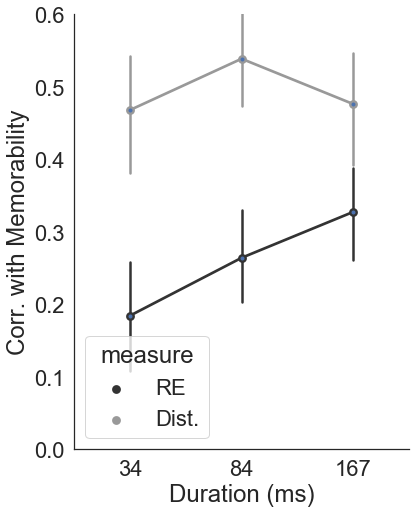

In [ ]:
sns.set(font_scale=2)
sns.set_style('white')
plt.figure(figsize=(6,8))
curr_ax = sns.pointplot(x='duration', y = 'r', hue='measure', ci=None, hue_order=['RE', 'Dist.'], 
                        palette = ['#333333','#999999'],
              data=corr_df_sampled)
# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in curr_ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

pairs_order = [('RE',2), ('RE',5), ('RE', 10), ('Dist.',2), ('Dist.',5), ('Dist.', 10)]
errorbars_list = []
for curr_ind, curr_pair in enumerate(pairs_order):
    curr_rs = corr_df_sampled[(corr_df_sampled['measure']==curr_pair[0])&
                             (corr_df_sampled['duration']==curr_pair[1])]['r'].values
    curr_rs.sort()
    errorbars_list.append((y_coords[curr_ind]-curr_rs[25], curr_rs[-25]-y_coords[curr_ind]))

plotline, caps, barlinecols =curr_ax.errorbar(x_coords, y_coords, 
                 yerr=np.array(errorbars_list).T,
                 fmt='.', lw=2.5,
                ecolor=['#333333']*3+['#999999']*3)

plt.setp(barlinecols[0], capstyle="round")


curr_ax.set_ylim(0,0.6)
curr_ax.set_xlim(-0.5, 2.5)
curr_ax.set_xticklabels(['34', '84', '167'])
curr_ax.set_xlabel('Duration (ms)')
curr_ax.set_ylabel('Corr. with Memorability')

sns.despine(top=True, right=True)

In [ ]:

print(performance_summary_targets)

                                      sub               condition  hit  fa  \
0    17a0b95a-caef-46b5-afdd-2ee194101fff                          NaN NaN   
1    17a0b95a-caef-46b5-afdd-2ee194101fff  Dist_Small_RE_Small_10  NaN NaN   
2    17a0b95a-caef-46b5-afdd-2ee194101fff  Dist_Large_RE_Large_10  NaN NaN   
3    17a0b95a-caef-46b5-afdd-2ee194101fff   Dist_Large_RE_Large_5  NaN NaN   
4    17a0b95a-caef-46b5-afdd-2ee194101fff   Dist_Large_RE_Large_2  NaN NaN   
..                                    ...                     ...  ...  ..   
143  fee306a7-c87d-4874-98a7-c3b90159186d  Dist_Small_RE_Small_10  NaN NaN   
144  fee306a7-c87d-4874-98a7-c3b90159186d  Dist_Small_RE_Large_10  NaN NaN   
145  fee306a7-c87d-4874-98a7-c3b90159186d  Dist_Large_RE_Large_10  NaN NaN   
146  fee306a7-c87d-4874-98a7-c3b90159186d   Dist_Small_RE_Small_2  NaN NaN   
147  fee306a7-c87d-4874-98a7-c3b90159186d  Dist_Large_RE_Small_10  NaN NaN   

     dprime response_type  probe_hit  probe_fa  probe_dprime du